# Multinomial logistic model for three-class classifition of the Iris dataset

We look at the `Iris` dataset from `R. A. Fisher (1936)` and use the sepal and petal characteristics to determine species.

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import scipy as sp
import pymc3 as pm

import matplotlib.pyplot as plt
from matplotlib.cm import Set1

plt.style.use('seaborn-whitegrid')

In [3]:
def summarize(alpha=0.05):

    def _summarize(ser):
        hpd_ = pm.hpd(ser, alpha=alpha)
        return pd.Series({
            'mean_': ser.mean(),
            'lower': hpd_[0],
            'upper': hpd_[1],
        })

    return _summarize


def agg_prediction(trace_var, source_data, group_columns, aggregate_fc):
    df = pd.DataFrame(trace_var).stack().reset_index().drop('level_0', axis=1)
    merged = pd.merge(
        df, source_data[group_columns],
        left_on='level_1', right_index=True
    )

    return (
        merged.groupby(group_columns)[0].apply(aggregate_fc)
        .unstack().sort_index().reset_index()
    )


## Loading the data

In [4]:
data = pd.read_csv('iris.csv')
species_idx = (data.species.drop_duplicates().reset_index(drop=True).reset_index()
               .set_index('species')['index'].rename('species_i').to_frame())
data = data.merge(species_idx, on=['species'])
data.sample(5)

,sepal_length,sepal_width,petal_length,petal_width,species,species_i
84,5.4,3.0,4.5,1.5,versicolor,1
117,7.7,3.8,6.7,2.2,virginica,2
136,6.3,3.4,5.6,2.4,virginica,2
22,4.6,3.6,1.0,0.2,setosa,0
135,7.7,3.0,6.1,2.3,virginica,2


In [5]:
data_agg = data.copy().reset_index()
data_agg = data_agg.set_index(
    ['index', 'sepal_length', 'sepal_width', 'petal_length', 'petal_width',
     'species_i']
).assign(cnt=1).cnt.unstack(fill_value=0).reset_index()

print(data_agg.shape)
data_agg.sample(5)

(150, 8)


species_i,index,sepal_length,sepal_width,petal_length,petal_width,0,1,2
3,3,4.6,3.1,1.5,0.2,1,0,0
76,76,6.8,2.8,4.8,1.4,0,1,0
34,34,4.9,3.1,1.5,0.2,1,0,0
56,56,6.3,3.3,4.7,1.6,0,1,0
69,69,5.6,2.5,3.9,1.1,0,1,0


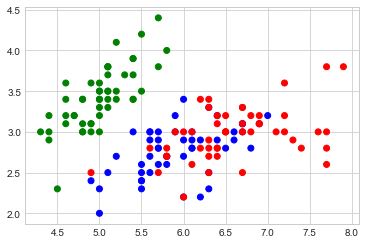

In [6]:
plt.scatter(data.sepal_length, data.sepal_width,
            c=np.array(['g', 'b', 'r'])[data.species_i])
None

## Model

We use 2 logistic models: one to determine the rate $p_0$ of the class being the $species = 0 $ and the the second to determine the rate $p_1$ of $species = 1$ when $species \neq 0$

$$ logit p_0 = a_0 + \mathbf{b}_0 \cdot \mathbf{x} $$


$$ logit p_1 = a_1 + \mathbf{b}_1 \cdot \mathbf{x} $$

where $\mathbf{x}$ is the feature vector with the four features: petal and sepal lenght and width; and $a$ and $\mathbf{b}$ are the intercepts and coefficients with the following priors:

$$ a \sim \text {Normal}(0, 1.5) $$

$$ b \sim \text{Normal}(0, 4) $$

Then, the rate of one of the three species would be:

$$ P_0 = p_0 $$

$$ P_1 = (1 - P_0) p_1 $$

$$ P_2 = 1 - P_0 - P_1 $$

Finally, the outcome, defined as a vector with counts of the three species, if modeled as a multinomial distribution:

$$ \textbf{outcome} \sim \text{Multinomial}(n=1, p=\textbf{P}) $$

$$ \textbf{P} = (P_0, P_1, P_2) $$

In [7]:
with pm.Model() as m1:
    a = pm.Normal('a', mu=0, sd=1.5, shape=2)
    b = pm.Normal('b', mu=0, sd=4, shape=(4, 2))

    p = pm.math.invlogit(
        a
        + pm.math.matrix_dot(
            data[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values,
            b,
        )
    )

    _P0 = p[:, 0]
    _P1 = (1 - _P0) * p[:, 1]
    P = pm.Deterministic(
        'P',
        pm.math.stack([_P0, _P1, 1 - _P0 - _P1]).T
    )

    obs = pm.Multinomial('obs', n=1, p=P,
                         observed=data_agg[[0, 1, 2]].values)

    m1.trace = pm.sample(2000, tune=2000, chains=2)

/home/petrushev/etc/jup_env/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]
Sampling 2 chains: 100%|██████████| 8000/8000 [01:42<00:00, 78.11draws/s] 
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [9]:
pm.waic(m1.trace, model=m1)

WAIC_r(WAIC=29.039214891818126, WAIC_se=7.123660997894726, p_WAIC=2.1528960292579624, var_warn=1)

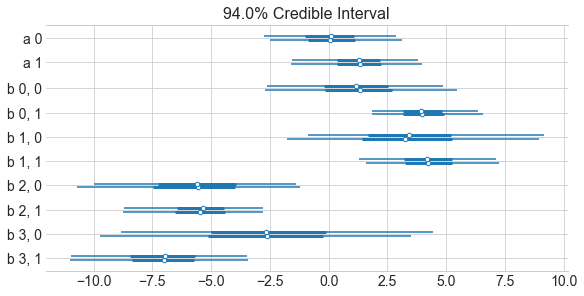

In [11]:
fig, ax = pm.plot_forest(m1.trace, var_names=['a', 'b'],
                         figsize=(8, 4))
ax[0].grid()
None

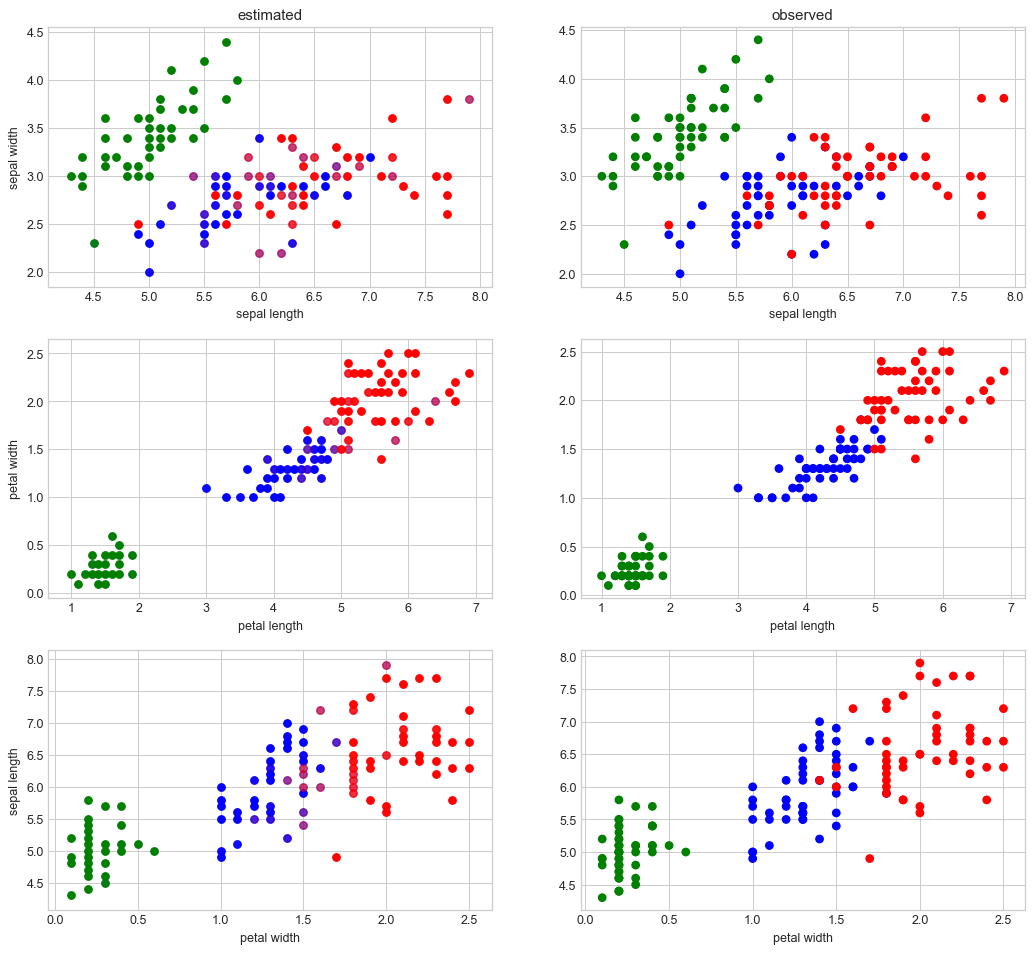

In [12]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(14, 13), dpi=90)

for (sp_name, sp_row), c in zip(species_idx.iterrows(), ('g', 'b', 'r')):
    tmp = agg_prediction(m1.trace['P'][:,:,sp_row.species_i], data_agg,
                         ['sepal_length', 'sepal_width'], summarize())
    for _, row in tmp.iterrows():
        ax1.scatter(row.sepal_length, row.sepal_width,
                    color=c, alpha=row.mean_)

    tmp = agg_prediction(m1.trace['P'][:,:,sp_row.species_i], data_agg,
                         ['petal_length', 'petal_width'], summarize())
    for _, row in tmp.iterrows():
        ax3.scatter(row.petal_length, row.petal_width,
                    color=c, alpha=row.mean_)
        
    tmp = agg_prediction(m1.trace['P'][:,:,sp_row.species_i], data_agg,
                         ['petal_width', 'sepal_length'], summarize())
    for _, row in tmp.iterrows():
        ax5.scatter(row.petal_width, row.sepal_length,
                    color=c, alpha=row.mean_)
        
ax2.scatter(data.sepal_length, data.sepal_width,
            c=np.array(('g', 'b', 'r'))[data.species_i])        
ax4.scatter(data.petal_length, data.petal_width,
            c=np.array(('g', 'b', 'r'))[data.species_i])
ax6.scatter(data.petal_width, data.sepal_length,
            c=np.array(('g', 'b', 'r'))[data.species_i])

ax1.set(title='estimated', xlabel='sepal length', ylabel='sepal width')
ax2.set(title='observed', xlabel='sepal length')
ax3.set(xlabel='petal length', ylabel='petal width')
ax4.set(xlabel='petal length')
ax5.set(xlabel='petal width', ylabel='sepal length')
ax6.set(xlabel='petal width')
None